# Lecture 6: Principle Component Analysis and Factor Analysis

In data science we explicity often deal with **multivariate** data, that means we have many observables which are often in relation with each other. 

We already explored how correlation between different variables can give us a hint on how the different variables depend on each other and we have also looked into non-linear relationships. 
However, data science often deals with datasets which are so large and contain so many different variables, that it is impossible to obtain meaningful predictors from individual variable correlations. 

The key against this problem is **dimensionality reduction**. 

## 6.1 Why dimensionality reduction?

With a large number of variables, the covariance matrix may be too large to study and interpret properly. There would be too many pairwise correlations between the variables to consider. Graphical displays may also not be particularly helpful when the data set is very large. With 12 variables, for example, there will be more than 200 three-dimensional scatterplots.

**The covariance matrix**

Let's recall what the *covariance matrix* of a dataset expresses. We take the dataset of trace gases, aerosol measurements and meteorolgical data measured in Helsinki from 2016-2024 as our example. Let's load the data first and compute the *covariance matrix*: 

In [1]:
import pandas as pd

met = pd.read_csv('./smeardata_meteorology_20250521.csv', na_values='NaN')
rad = pd.read_csv('./smeardata_radiation_20250516.csv', na_values='NaN')
aer = pd.read_csv('./smeardata_aerosol_20250516.csv', na_values='NaN')
gas = pd.read_csv('./smeardata_tracegases_20250516.csv', na_values='NaN')

hel = pd.concat([met, rad.iloc[:, 6:], aer.iloc[:, 6:], gas.iloc[:, 6:]], axis=1)
hel['time'] = pd.to_datetime(hel[['Year', 'Month', 'Day', 'Hour', 'Minute']])
hel.set_index('time', drop=True, inplace=True)
hel.drop(['Year', 'Month', 'Day', 'Hour', 'Minute','Second'], axis=1, inplace=True)

hel

,KUM_META.t,KUM_META.rh,KUM_META.Tower_GLOB_32m,KUM_META.PM10_TEOM,KUM_META.BC_MAAP,KUM_META.cn,KUM_META.PM25_TEOM,KUM_META.NO_x,KUM_META.O_3,KUM_META.SO_2,KUM_META.NO,KUM_META.CO
time,,,,,,,,,,,,
2016-01-01 00:00:00,-4.23667,72.61667,-0.76114,NaN,335.66667,1681.87015,NaN,1.85612,32.89726,0.41129,0.30276,222.54869
2016-01-01 01:00:00,-4.14167,74.51667,-0.44727,NaN,310.00000,1287.12972,NaN,1.30323,32.07375,0.22075,0.08657,224.13809
2016-01-01 02:00:00,-4.01000,75.56667,-0.42373,NaN,290.08333,846.27716,NaN,1.44487,30.89310,0.17540,0.20024,223.09605
2016-01-01 03:00:00,-4.06500,74.85000,-0.45512,NaN,268.83333,812.86557,NaN,1.00533,31.49488,0.22823,0.02059,221.28508
2016-01-01 04:00:00,-3.70667,74.80000,-0.45512,NaN,295.83333,787.59820,NaN,1.01526,30.16043,0.40940,0.00595,224.44008
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,-2.20500,67.58333,-5.10726,11.02256,0.21833,2471.72683,4.56977,1.76062,34.56158,0.14264,-0.04219,122.10526
2024-12-31 20:00:00,-2.51500,70.75000,-5.07984,12.06676,0.32667,3361.03897,6.56455,1.96434,33.63039,0.13856,0.02323,125.00000
2024-12-31 21:00:00,-2.80667,73.91667,-4.44537,10.53718,0.37250,4408.51152,6.45151,1.70159,32.90421,0.09110,0.06598,128.42105


In [2]:
hel.cov()

,KUM_META.t,KUM_META.rh,KUM_META.Tower_GLOB_32m,KUM_META.PM10_TEOM,KUM_META.BC_MAAP,KUM_META.cn,KUM_META.PM25_TEOM,KUM_META.NO_x,KUM_META.O_3,KUM_META.SO_2,KUM_META.NO,KUM_META.CO
KUM_META.t,77.300344,-58.965617,812.594310,7.614999,-318.337433,-1.016152e+03,-1.686195,-19.871928,28.994623,-0.567767,-8.852719,-286.296610
KUM_META.rh,-58.965617,315.723179,-2021.057614,-41.018475,289.202392,-1.033330e+04,1.629179,13.961550,-98.782442,-1.399511,3.837123,160.406598
KUM_META.Tower_GLOB_32m,812.594310,-2021.057614,40740.178166,281.902870,-3611.786104,7.842375e+04,-22.968384,-92.536644,770.786717,21.286225,31.390301,-2524.334492
KUM_META.PM10_TEOM,7.614999,-41.018475,281.902870,740.617163,1304.652727,9.898632e+03,756.168965,33.623082,7.139398,0.890502,15.400283,153.322586
KUM_META.BC_MAAP,-318.337433,289.202392,-3611.786104,1304.652727,150557.457403,4.226317e+05,678.077357,1928.582372,-803.911331,32.652220,1259.696644,9673.291473
KUM_META.cn,-1016.151680,-10333.304020,78423.754518,9898.631637,422631.662634,9.539465e+06,3506.777118,21260.017330,-7982.520539,588.854555,11774.138731,65097.088343
KUM_META.PM25_TEOM,-1.686195,1.629179,-22.968384,756.168965,678.077357,3.506777e+03,829.288074,16.681072,-2.438280,0.274942,7.650788,105.469704
KUM_META.NO_x,-19.871928,13.961550,-92.536644,33.623082,1928.582372,2.126002e+04,16.681072,120.310627,-47.418831,1.437749,75.930422,368.334300
KUM_META.O_3,28.994623,-98.782442,770.786717,7.139398,-803.911331,-7.982521e+03,-2.438280,-47.418831,108.555787,0.067272,-20.890247,-208.245772
KUM_META.SO_2,-0.567767,-1.399511,21.286225,0.890502,32.652220,5.888546e+02,0.274942,1.437749,0.067272,0.946346,0.736439,7.013071


We have:
$$
\text{Cov}(X, Y) = E((X-E(X))\cdot(Y-E(Y))) = \frac{1}{n} \sum_m^n (x_m - \mu_x)\cdot(y_m-\mu_y)
$$
with $X$ and $Y$ being each $n$ observations of two of the multivariate dataset (of $p$ observed variables) to be investigated. The value of this metric provides information about whether high values of one random variable tend to be associated with high or low values of the other random variable. Covariance is a measure of association, i.e., it quantifies the degree of (in)dependence between two random variables.

**Breaking down the covariance matrix**

Assume that we transform our observations $X_{i}$ into:
$$
\begin{align}
Y_1 &= e_{11}X_1 + e_{12}X_2 + ... + e_{1,p}X_p \\
Y_2 &= e_{21}X_1 + e_{22}X_2 + ... + e_{2,p}X_p \\
&... \\
Y_p &= e_{p1}X_1 + e_{p2}X_2 + ... + e_{p,p}X_p 
\end{align}
$$
i.e. we rewrote everything as a linear combination of the initial variables. Each of these can be thought of as linear regression, predicting $Y_i$ from $X_1, X_2, ..., X_p$ with the regression coefficients $e_{i1}, e_{i2}, ... , e_{ip}$, different for each $i$. 

The variance of these new variables is given by $\text{Var}(Y_1)$:
$$
\text{Var}(Y_1) = \frac{1}{n} \sum_m^n (y_1(m)-E(Y_1))^2 = \sum_l^p \sum_k^p e_{1l}e_{1k}\text{Var}(X_l, X_k)
$$
or generally:
$$
\text{Var}(Y_i) = \frac{1}{n} \sum_m (y_i(m)-E(Y_1))^2 = \sum_l^p \sum_k^p e_{il}e_{ik}\text{Var}(X_l, X_k)
$$

**Reducing dimensions**

When we have a correlation (multicollinearity) between the x-variables, the data may more or less fall on a line or plane in a lower number of dimensions. For instance, imagine a plot of two x-variables that have a nearly perfect correlation. The data points will fall close to a straight line. That line could be used as a new (one-dimensional) axis to represent the variation among data points. Our aim is to find these redundant directions in our Covariance matrix. 

## 6.2 The principle components

If we now optimize the search for these regression coefficients $e_{1l}$ such that we try to maximize the variance of $Y_{1}$, then $Y_{1}$ would represent a variable which incoporates most of the variation found in the original data $X_i$. Generally speaking, this would mean that with the found linear combination we can explain almost most of the differences in the original data. That's why $Y_1$ can then be called the **first principle component**. 

**How to find the coefficients for the principle components?**

Interestingly, the solution to this problem involves the eigenvalues and eigenvectors of the covariance matrix. 

Recall that an eigenvector stays in the same direction upon matrix multiplication, instead of rotating or changing direction  — they are the matrix’s "natural directions". In mathematical terms:
$$
A e=\lambda e
$$
In that case $e$ is an *eigenvector* of $A$ and $\lambda$ the corresponding *eigenvalue*. 

The natural direction of the Covariance matrix are the *eigenvectors* (they are orthogonal to each other), and therefore it is logical that they represent the set of coefficients $e_{ip}$ we are looking for. In addition, the larger the *eigenvalue* of a certain *eigenvector* is, the larger the matrix (i.e. the covariances) stretch out into that direction. This means, the problem described above can be summarized as follows:

1. find the *eigenvectors* and *eigenvalues* of the covariance matrix $\text{Cov}(X)=\Sigma$
2. sort the *eigenvalues*
3. the largest *eigenvalues* and corresponding *eigenvectors* explain most of the variability in the original data $X$

An eigenwert problem of a square, symmetric matrix is easily solved using [`np.linalg.eigh`](https://numpy.org/doc/2.1/reference/generated/numpy.linalg.eigh.html)

In [3]:
import numpy as np

A = np.array(hel.cov())
lambdas, E = np.linalg.eigh(A)

lambda1 = np.argmax(lambdas)
E[lambda1]

array([-4.26788366e-04, -7.93609563e-03,  1.98629367e-02,  9.53826563e-02,
        1.61949504e-03, -6.04125163e-02, -5.93271958e-02, -8.63949180e-02,
        9.84020005e-01,  6.77153488e-02, -5.36723490e-02, -6.84806257e-03])

**How to interprete the principle components?**

The proportion of variation explained by the ith principal component is then defined to be the eigenvalue for that component divided by the sum of the eigenvalues. In other words, the ith principal component explains the following proportion of the total variation:
$$
\frac{\lambda_i}{\lambda_1+\lambda_2+...+\lambda_p}
$$
A related quantity is the proportion of variation explained by the first k principal component. This would be the sum of the first k eigenvalues divided by its total variation.
$$
\frac{\lambda_1+\lambda_2+...+\lambda_k}{\lambda_1+\lambda_2+...+\lambda_p}
$$
Naturally, if the proportion of variation explained by the first k principal components is large, then not much information is lost by considering only the first k principal components.

## 6.3 Principle Component Analysis

### 6.3.1 Standardization

PCA will tend to give more emphasis to those variables that have higher variances than to those variables that have lower variances, as it works to solve the *eigenvalue*-problem of the Covaraiance matrix (which is not normalized). 

In effect, the results of the analysis will depend on the units of measurement used to measure each variable. That would imply that a principal component analysis should only be used with the raw data if all variables have the same units of measure. 

**Example**: Think of an ecological setting where you are looking at counts of different species of organisms at a number of different sample sites. Here, one may want to give more weight to the more common species that are observed. By analyzing the raw data you will tend to find that more common species will also show higher variances and will be given more emphasis. If you were to do a principal component analysis on standardized counts, all species would be weighted equally regardless of how abundant they are. This might be wanted or unwanted, and needs to be decided by the data scientist.  

A straight-foward way to make the variables comparable, is to *standardize* them by the following transformation:
$$
z_i = \frac{x_i-\mu_x}{\sigma_x}
$$
This means all variables $Z$ used in the PCA have mean 0 and variance 1 &rarr; they are now **comparable**! 

The python library [`scikit-learn`](https://scikit-learn.org/stable/) provides a straight forward way to standardize even huge datasets:

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hel_scaled = scaler.fit_transform(hel)
hel_scaled = pd.DataFrame(hel_scaled, index=hel.index, columns=hel.columns)
hel_scaled

,KUM_META.t,KUM_META.rh,KUM_META.Tower_GLOB_32m,KUM_META.PM10_TEOM,KUM_META.BC_MAAP,KUM_META.cn,KUM_META.PM25_TEOM,KUM_META.NO_x,KUM_META.O_3,KUM_META.SO_2,KUM_META.NO,KUM_META.CO
time,,,,,,,,,,,,
2016-01-01 00:00:00,-1.289340,-0.158528,-0.586859,NaN,0.378305,-0.856290,NaN,-0.456848,0.618076,0.176543,-0.168712,0.720798
2016-01-01 01:00:00,-1.278534,-0.051598,-0.585304,NaN,0.312156,-0.984096,NaN,-0.507255,0.539036,-0.019325,-0.197282,0.748326
2016-01-01 02:00:00,-1.263558,0.007496,-0.585188,NaN,0.260826,-1.126833,NaN,-0.494342,0.425719,-0.065943,-0.182260,0.730278
2016-01-01 03:00:00,-1.269814,-0.032838,-0.585343,NaN,0.206060,-1.137650,NaN,-0.534415,0.483477,-0.011636,-0.206001,0.698912
2016-01-01 04:00:00,-1.229058,-0.035652,-0.585343,NaN,0.275645,-1.145831,NaN,-0.533509,0.355398,0.174601,-0.207936,0.753556
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,-1.058258,-0.441802,-0.608392,0.108605,-0.486222,-0.600556,0.047962,-0.465555,0.777816,-0.099619,-0.214298,-1.018877
2024-12-31 20:00:00,-1.093518,-0.263583,-0.608256,0.146975,-0.485943,-0.312620,0.117233,-0.446982,0.688441,-0.103813,-0.205652,-0.968741
2024-12-31 21:00:00,-1.126692,-0.085365,-0.605112,0.090770,-0.485825,0.026523,0.113307,-0.470937,0.618743,-0.152600,-0.200003,-0.909488


We remember that the *correlation matrix* was given by:
$$
\text{Corr}(X, Y) = \text{Cov}(X, Y)/\sqrt{\text{Var}(X) \cdot \text{Var}(Y)}
$$
So simply put, the correlation matrix contains the covariances of all variable pairs of the multivariate datset devided by the individual variances. That way all covariances get normalized as well and independent of the original units. So solving the *eigenvalue* problem for the *correlation matrix* is the same than doing PCA on standardized variables. 

### 6.3.2 PCA in `scikit-learn`

Instead of solving the *eigenvalue* problem step-by-step, ordering the *eigenvalues* and then extracting the components, [`scikit-learn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) provides the functionality directly. Moreover, it uses a more robust approach for solving the *eigenvalue* problem. 

It is important to note that `sklearn.decomposition.PCA` cannot deal with input `NaN`, which is often a [problem](https://stackoverflow.com/questions/29420737/pca-with-missing-values-in-python).

To solve this, we need to either drop the `NaN` data or use some padding technique which we have learnt until now. Straight forward is to just fill in the mising data with the column mean (as for standardization we anyways try to get rid of the mean), but then the application of PCA is straight-forward: 

In [5]:
from sklearn.decomposition import PCA

hel_clean = hel.fillna(hel.mean())
scaler = StandardScaler()
hel_scaled = scaler.fit_transform(hel_clean)
pca = PCA(n_components=3)
hel_pca = pca.fit_transform(hel_scaled)

hel_pca = pd.DataFrame(hel_pca, index=hel_clean.index, columns=[f'PC{i+1}' for i in range(hel_pca.shape[1])])
hel_pca

,PC1,PC2,PC3
time,,,
2016-01-01 00:00:00,0.080922,0.791820,0.416598
2016-01-01 01:00:00,0.015686,0.954363,0.495182
2016-01-01 02:00:00,-0.002148,1.058972,0.538256
2016-01-01 03:00:00,-0.087427,1.040731,0.537988
2016-01-01 04:00:00,0.005207,1.027123,0.522135
...,...,...,...
2024-12-31 19:00:00,-1.069394,0.515595,0.485905
2024-12-31 20:00:00,-0.861052,0.512116,0.560427
2024-12-31 21:00:00,-0.681599,0.561696,0.503952


Let's inspect the time series of the principal components:

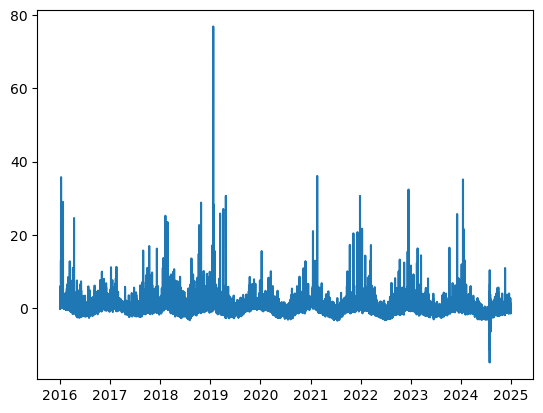

In [6]:
import matplotlib.pyplot as plt

plt.plot(hel_pca.index, hel_pca['PC1'])

And their annual and seasonal medians:

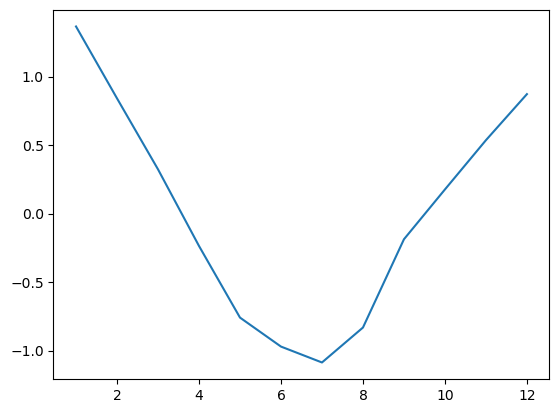

In [7]:
hel_pca_monthly = hel_pca.groupby(hel_pca.index.month).mean()
plt.plot(hel_pca_monthly.index, hel_pca_monthly['PC1'])

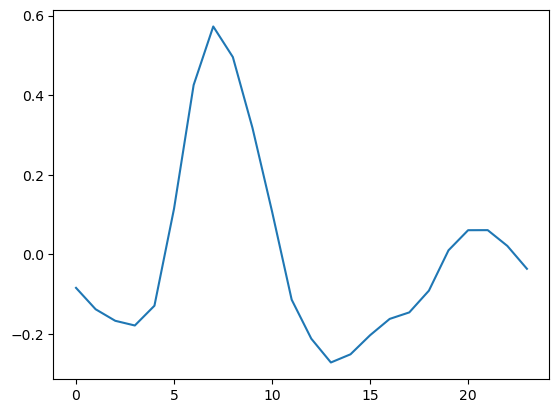

In [8]:
hel_pca_daily = hel_pca.groupby(hel_pca.index.hour).mean()
plt.plot(hel_pca_daily.index, hel_pca_daily['PC1'])

`sklearn.decomposition.PCA` also provides direct access to the variance explained by our first principal components.

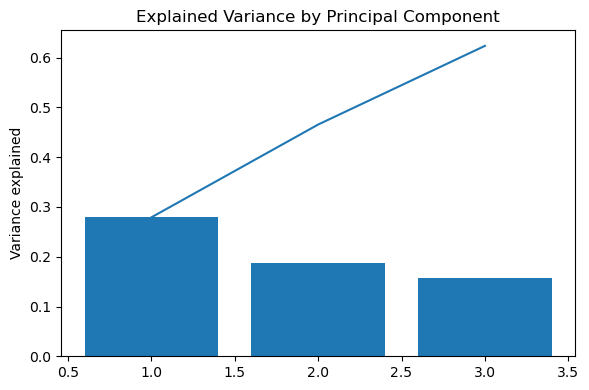

In [9]:
plt.figure(figsize=(6, 4))
plt.bar(range(1, 4), pca.explained_variance_ratio_)
plt.plot(range(1, 4), pca.explained_variance_ratio_.cumsum())
plt.ylabel('Variance explained')
plt.title('Explained Variance by Principal Component')
plt.tight_layout()
plt.show()

In [10]:
loadings = pca.components_
loadings

array([[-2.70888369e-01,  1.72867263e-01, -1.65407857e-01,
         7.95910006e-02,  2.79748856e-01,  3.20838113e-01,
         6.60564894e-02,  4.71271643e-01, -3.29913197e-01,
         8.98727307e-02,  4.19839307e-01,  4.02740743e-01],
       [-3.35080377e-01,  4.81847720e-01, -4.69217274e-01,
        -3.15089977e-01, -1.28561362e-01, -2.92784824e-01,
        -2.63166250e-01, -1.77730973e-01, -2.61814121e-01,
        -1.43982889e-01, -2.04801126e-01,  4.21949481e-02],
       [-1.18475323e-01,  1.90130602e-01, -2.04364364e-01,
         6.25166527e-01, -4.36267207e-02, -1.69991711e-01,
         6.54422046e-01, -1.42617788e-01, -5.86150007e-02,
        -8.42062139e-02, -1.65168847e-01, -5.47371220e-04]])

In [11]:
hel_clean.iloc[:, 8].name

'KUM_META.O_3'

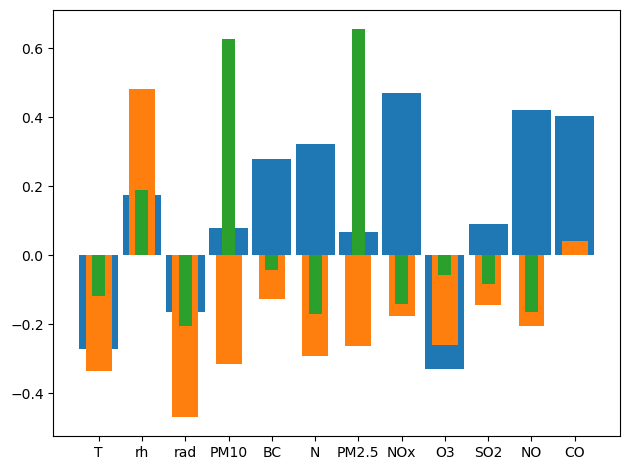

In [13]:
var_names = ['T','rh','rad','PM10','BC','CN','PM2.5','NOx','O3','SO2','NO','CO']

plt.bar(var_names, pca.components_[0], width=0.9)
plt.bar(var_names, pca.components_[1], width=0.6)
plt.bar(var_names, pca.components_[2], width=0.3)
plt.tight_layout()
plt.show()

We see that the first principal component is dominated by **NO$_x$**, **NO**, **CO** and **CN**, exhibts a clear seasonal feature with winter maximum and a daily pattern with morning time maximum. Especially the daily pattern looks like traffic being a dominant contributor. 

**This means, our PCA has revealed that more than 25% of the variation in air quality monitoring data can be attributed to a strong traffic source.**

In contrast the second largest principal component is dominated **PM$_{10}$** and **PM$_{2.5}$**, no other variables seem to stick out. It has a spring to summer maximum and a diurnal cycle following closely with temperature. What could it be? The third principal component has similar diurnal and seasonal pattern but is dominated by **global radiation** and **ozone**. It is following very clearly the oxidizing capacity of the atmosphere, probably photochemistry as air pollution source. 

One can interpret this component by component. One method of deciding how many components to include is to choose only those that give unambiguous results, i.e., where no variable appears in two different columns as a significant contribution.

**Note!** The primary purpose of this analysis is descriptive - it is not hypothesis testing! So your decision in many respects needs to be made based on what provides you with a good, concise description of the data.

## 6.4 Factor Analysis

### 6.4.1  Statistical Modeling instead of Geometric Decomposition

In PCA, the interpretation of the principal components is often not very clean. A particular variable may, on occasion, contribute significantly to more than one of the components.

In factor analysis we turn the tables around: We try to model the observed variables, and their covariance structure, in terms of a smaller number of underlying unobservable (latent) “factors.” The factors typically are viewed as broad concepts or ideas that may describe an observed phenomenon.

Instead of assigning with a linear combination the observed variables to new variables (the principal components), we try to express the observed variables as a combination of the factors:

$$
\begin{align}
X_1 &= \mu_1 + l_{11}f_1 + l_{12}f_2 + ... + l_{1,m}f_m + \epsilon_1 \\
X_2 &= \mu_2 + l_{21}f_1 + l_{22}f_2 + ... + l_{2,m}f_m + \epsilon_2 \\
&... \\
X_p &= \mu_p + l_{p1}f_1 + l_{p2}f_2 + ... + l_{p,m}f_m + \epsilon_p
\end{align}
$$
If we think that each $X_i$ has $n$ observations in time, then for each observation at time-step $m$ we assume:
$$
x_{m} = \mu + L f_{m} + \epsilon_m 
$$

Or, more general in matrix-notation:
$$
X = \mu + LF + \epsilon
$$

And remember, that we often deal with *centered* data, so we reduce the model to:
$$
X' = X-\mu = LF + \epsilon
$$

Let's quickly recall the dimensions of our variables, factors and loadings:

- $X \in \mathbb{R}^{p \times n}$: Are our $p$ observed variables (SO$_2$, NO$_x$, etc.) at $n$ different timepoints. 
- $L \in \mathbb{R}^{k \times p}$: Are the $k$ time-independent loadings of the factors, i.e. how much each of the $p$ observed variable contribute to each factor. We can identify these factors as potential *source profiles* in our dataset. 
- $f \in \mathbb{R}^{n \times k}$: Are the factor scores, giving strengths of each factor $k$ for each timepoint $n$. They model the variability in the data.
- $\epsilon$ are the $p$ residuals, that means the specific (unshared) variance of each variable $p$ at the timepoints $n$

In summary, the basic model is like a regression model. Importantly, for the model we assume:
- $\text{Cov}(f_i) = I_k$
- $\text{Cov}(\epsilon_i) = \Psi = \text{diag}(\psi_1, \dots, \psi_p)$

Under these assumptions, FA tries to find model coefficients ($L$, $\Psi$) to describe the observations $X$ (through regression).

&rarr; We now see that the underlying model is different in FA than in PCA:
$$
\text{Cov}(X, Y) = LL^T + \Psi 
$$

Factor anaylsis says that the covariance in the data can be explained by shared (co-)variance ($LL^T$) of a lower rank and some unqiue/specific variance of each variable ($\Psi=Cov(\epsilon)=diag(\psi_1, \psi_2, ... , \psi_p)$). While, PCA aims to explain all variance in the data using a new set of directions such that higher-order components can be truncated at they contribute little to the explained variance, Factor Analysis (FA) assumes that only the common variance among variables is explained by a smaller set of latent factors, while residual variance specific to each variable (unique variance) is explicitly modeled and not explained by the common factors.

**PCA will try to explain all variation in NO$_x$, SO₂, CO, etc., even variation that's unique to a sensor or a random fluctuation. In FA, some of this variation is shared between pollutants (due to common sources), and some is just unique sensor error or local effects, the factors are not forced to explain that part!**

### 6.4.2 Factor Analysis step-by-step

**Goal**:

Estimate $L$ and $\Psi$ such that the **observed covariance** $\Sigma$ is approximated by:

$$
\Sigma \approx LL^\top + \Psi
$$

**Data Preparation**

- **Input**: Matrix $X \in \mathbb{R}^{n \times p}$
- **Center** the data (subtract mean of each variable)
- **Do not necessarily standardize** unless variables are on different scales (units) and comparability is desired
- **Handle missing values**: impute or remove incomplete rows

So up-to-now there is nothing new (and for our dataset with different units we still need to standardize):

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hel_scaled = scaler.fit_transform(hel)
hel_scaled = pd.DataFrame(hel_scaled, index=hel.index, columns=hel.columns)
hel_scaled

,KUM_META.t,KUM_META.rh,KUM_META.Tower_GLOB_32m,KUM_META.PM10_TEOM,KUM_META.BC_MAAP,KUM_META.cn,KUM_META.PM25_TEOM,KUM_META.NO_x,KUM_META.O_3,KUM_META.SO_2,KUM_META.NO,KUM_META.CO
time,,,,,,,,,,,,
2016-01-01 00:00:00,-1.289340,-0.158528,-0.586859,NaN,0.378305,-0.856290,NaN,-0.456848,0.618076,0.176543,-0.168712,0.720798
2016-01-01 01:00:00,-1.278534,-0.051598,-0.585304,NaN,0.312156,-0.984096,NaN,-0.507255,0.539036,-0.019325,-0.197282,0.748326
2016-01-01 02:00:00,-1.263558,0.007496,-0.585188,NaN,0.260826,-1.126833,NaN,-0.494342,0.425719,-0.065943,-0.182260,0.730278
2016-01-01 03:00:00,-1.269814,-0.032838,-0.585343,NaN,0.206060,-1.137650,NaN,-0.534415,0.483477,-0.011636,-0.206001,0.698912
2016-01-01 04:00:00,-1.229058,-0.035652,-0.585343,NaN,0.275645,-1.145831,NaN,-0.533509,0.355398,0.174601,-0.207936,0.753556
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,-1.058258,-0.441802,-0.608392,0.108605,-0.486222,-0.600556,0.047962,-0.465555,0.777816,-0.099619,-0.214298,-1.018877
2024-12-31 20:00:00,-1.093518,-0.263583,-0.608256,0.146975,-0.485943,-0.312620,0.117233,-0.446982,0.688441,-0.103813,-0.205652,-0.968741
2024-12-31 21:00:00,-1.126692,-0.085365,-0.605112,0.090770,-0.485825,0.026523,0.113307,-0.470937,0.618743,-0.152600,-0.200003,-0.909488


**Estimating Loadings $L$ and Uniquenesses $\Psi$**

There are several approaches how to find $L$ and $\Psi$ using optimization (fitting):

| Method                        | Optimizes / Minimizes                                                                     | Assumptions                   | Iterative | Uses eigen decomposition   | Fit statistics |
| ----------------------------- | ----------------------------------------------------------------------------------------- | ----------------------------- | --------- | -------------------------- | -------------- |
| **Principal Axis Factoring**  | Difference between observed and model-implied **diagonals** (communalities)               | No distributional assumptions | Yes       | Yes                        | No             |
| **Minimum Residual (MinRes)** | Sum of squared **off-diagonal residuals**:  $\sum_{i \neq j} (R_{ij} - (LL^\top)_{ij})^2$ | No distributional assumptions | Yes       | Often (for initialization) | No             |
| **Maximum Likelihood (MLFA)** | Negative log-likelihood under $X \sim \mathcal{N}(0, \Sigma = LL^\top + \Psi)$            | Multivariate normality        | Yes       | No                         | Yes            |

Let's look at such an algorithm step-by-step, here the most straight-forward **Principal Axis Factoring**, which has many similarities with PCA:
1. Start with some guess of the uniqueness (can be as simple as $\psi_i$=0.5 for all $i$)
2. Calculate the reduced covariance $ \text{Cov}_{red}=\text{Cov}-\Psi $
3. Perform a *eigen decomposition* of $ \text{Cov}_{red}$ as in PCA, obtaining the *eigenvalues* $\Lambda = \text{diag}(\lambda_1, ..., \lambda_p)$ and *eigenvectors* $V$ (matrix of all *eigenvectors*), i.e. rewrite $\text{Cov}_{red} = V \Lambda V^T $
4. As the model is $\text{Cov}(X, Y) = LL^T + \Psi$, we know that $LL^T = \text{Cov}_{red}$, and by taking only the first $k$ (assumed number of factors) *eigen decompositions* we can hence approximate $L \approx V_k \Lambda_k^{1/2}$
5. We can now update our initial guess of the uniqueness by $\psi_j = 1 - \sum_{i=1} L_{ij}^2$ and repeat the algorithm till convergence
We see that the algorithm in step 4. and 5. tries to optimize $L$ until $diag(LL^T + \Psi) = diag(\text{Cov})$, it tries to find the optimal solution for $L$ such that the variances of the indvidual observed variables are best explained by the set of $k$ common factors.

***In contrast***: MinRes tries to find a loading matrix $L$ such that the relationships between variables — that is, the off-diagonal entries of the correlation matrix — are best explained by a small number of common factors.

**Regress the factor scores $f$**

After the loadings $L$ and the uniqueness $\Psi$ have been estimated, we return to the model equation $X = LF + \epsilon$ and use a simple regression to optimize the factor scores such that across all timesteps $m \in N$ we achieve the minimum deviation for all $x_m = Lf_m + \epsilon_m$ (using a typical least-square approach is sufficient).

**Rotation**:

Last, we need to realize that Factor Analysis is a underdetermined problem, many different loading matrices can explain the same data equally well. 

*Why?* 

Assume we have an *orthogonal matrix* $T$ (i.e. $TT^T=I$) which we apply on both the loading matrix $L$ and the factor score matrix $F$: $L_{rot}=LT$ and $F_{rot} = T^TF$, which doesn't change the model as $X = L_{rot}F_{rot} + \epsilon = LTT^TF + \epsilon = LF + \epsilon$ and also doesn't change the covariance structure we optimized to fit with the model as $\text{Cov}(X) = L_{rot}L_{rot}^T + \Psi = LT(LT)^T + \Psi = LTT^TL^T + \Psi = LT + \Psi$

So we can apply any orthogonal matrix to our solution, to find another.

***Make use of it***: We can try to find rotations which make the solutions more meaningful. Factor loadings are often spread across many factors and we can try to find rotations which transform the solution such that variables have often a high load on one factor and are low on others 

&rarr; most python libraries for factor analysis provide these tools!

### 6.4.3 Factor analysis in practice: `scikit-learn` 

Let's perform factor analysis again on our Helsinki dataset.

We are using [`sklearn.decompose.FactorAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html), however, it needs to be pointed out that its abilities are quite limited. For more in-depth adjustement of FA parameters, solvers (e.g. scikit-learn only uses Maximum Likelihood for solving the problem), etc. the usage of the [`factor_analyzer`](https://pypi.org/project/factor-analyzer/) module is recommended but not covered here. 

Let's see how FA works in scikit-learn:

In [32]:
from sklearn.decomposition import FactorAnalysis

scaler = StandardScaler()
hel_scaled = scaler.fit_transform(hel_clean)
hel_scaled = pd.DataFrame(hel_scaled, index=hel.index, columns=hel.columns)

fa = FactorAnalysis(n_components=3, random_state=42)
fa.fit(hel_scaled)

fa.components_.T

/opt/conda/lib/python3.11/site-packages/sklearn/decomposition/_factor_analysis.py:299: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


array([[-1.94519373e-01, -4.62282393e-02,  5.31763794e-01],
       [ 6.63825237e-02,  7.38930389e-02, -7.92147120e-01],
       [-3.87100182e-02, -4.44547732e-02,  7.06378009e-01],
       [ 1.11606847e-01, -9.91900344e-01,  3.51981214e-03],
       [ 3.71205385e-01, -5.64433075e-02, -1.97853109e-02],
       [ 5.87543103e-01, -2.77144216e-02,  1.92664374e-01],
       [ 6.41402234e-02, -9.65759662e-01, -7.46778363e-02],
       [ 9.99347125e-01,  2.34470387e-02,  2.23805721e-04],
       [-4.00397110e-01, -6.29341986e-02,  5.43805407e-01],
       [ 1.26046033e-01, -1.21905301e-02,  9.78381390e-02],
       [ 9.14271464e-01,  4.30326411e-02,  7.46597187e-02],
       [ 5.14860523e-01, -1.42307816e-02, -2.45074642e-01]])

Apparently, there is a convergence issue. We already see, that peforming factor analysis might be much more challenging than PCA.

&rarr; this is no surprise, the underlying model to be fit is quite a challenging proceess especially if you have many many observations (time-steps

Let's try to further clean our dataset:

In [69]:
hel_smoothed = hel.rolling(window=6).median()
pos_outliers = hel_smoothed.loc[:, :] > hel_smoothed.loc[:, :].mean() + 5*hel_smoothed.loc[:, :].std()
neg_outliers = hel_smoothed.loc[:, :] < hel_smoothed.loc[:, :].mean() - 5*hel_smoothed.loc[:, :].std()
hel_smoothed[(pos_outliers | neg_outliers)] = np.nan
hel_smoothed.dropna(axis=0, inplace=True)

hel_smoothed

,KUM_META.t,KUM_META.rh,KUM_META.Tower_GLOB_32m,KUM_META.PM10_TEOM,KUM_META.BC_MAAP,KUM_META.cn,KUM_META.PM25_TEOM,KUM_META.NO_x,KUM_META.O_3,KUM_META.SO_2,KUM_META.NO,KUM_META.CO
time,,,,,,,,,,,,
2018-03-08 20:00:00,-3.862500,81.283335,7.889595,15.367480,917.083330,6798.922880,9.978860,15.552660,31.234680,0.924955,2.129470,217.817030
2018-03-08 21:00:00,-3.355835,83.641665,0.191460,14.318405,801.166665,6102.877555,9.978860,12.113385,34.033305,0.797070,1.077100,213.076470
2018-03-08 22:00:00,-3.145000,87.866665,0.018050,13.866300,726.250000,5447.809995,9.752625,9.878625,34.876760,0.729060,0.776010,212.008410
2018-03-08 23:00:00,-2.865000,92.075000,-0.014905,13.600815,667.583335,4732.788450,9.214995,7.323340,35.941980,0.639310,0.418265,210.812485
2018-03-09 00:00:00,-2.505835,92.983335,-0.057280,12.369000,660.125000,4046.609950,9.187480,5.459100,36.532475,0.565710,0.127255,209.480430
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,-1.499170,61.791665,-4.756195,10.960185,0.136670,1986.073125,2.319095,1.916480,34.760415,0.077825,0.017205,118.703300
2024-12-31 20:00:00,-1.701670,62.741665,-4.854550,11.005430,0.162920,2075.450690,2.729390,1.881685,34.669025,0.090075,0.017505,120.909775
2024-12-31 21:00:00,-2.000835,65.633330,-4.854550,10.901090,0.201250,2310.131465,3.826645,1.779825,34.669025,0.093395,0.024565,120.909775


Running the FA again, we see that convergence is achieved rapidly now:

In [35]:
scaler = StandardScaler()
hel_scaled = scaler.fit_transform(hel_smoothed)
hel_scaled = pd.DataFrame(hel_scaled, index=hel_smoothed.index, columns=hel_smoothed.columns)

fa = FactorAnalysis(n_components=3, random_state=42)
fa.fit(hel_scaled)

fa.components_.T

array([[-0.22585959, -0.32766754, -0.34006461],
       [ 0.09882069,  0.38735255,  0.73395094],
       [-0.05168887, -0.2706378 , -0.61995583],
       [ 0.36623467, -0.86604243,  0.0704006 ],
       [ 0.23855459, -0.28873256,  0.14607045],
       [ 0.60890578, -0.15407997, -0.27752409],
       [ 0.34257155, -0.73011222,  0.33589994],
       [ 0.98339392,  0.08515972, -0.02850917],
       [-0.47109192, -0.35500049, -0.4160085 ],
       [ 0.21513488, -0.15477593, -0.10214065],
       [ 0.8123336 ,  0.11465264, -0.1357838 ],
       [ 0.54841468, -0.06448505,  0.28311287]])

Let's see if the output changes, if we include a rotation to the results (using varimax, which tries to find a rotation such that individual variables get maximized in one component): 

In [63]:
fa = FactorAnalysis(n_components=3, random_state=42, rotation='varimax')
fa.fit(hel_scaled)

fa.components_.T

array([[-0.21542721, -0.13051667, -0.4588889 ],
       [ 0.02755545,  0.09087362,  0.83034582],
       [ 0.01863872, -0.03347179, -0.67734335],
       [ 0.16222155, -0.90609832, -0.20441031],
       [ 0.14146401, -0.37167545,  0.0587933 ],
       [ 0.60786533, -0.20837797, -0.24208442],
       [ 0.11436319, -0.86168271,  0.08758917],
       [ 0.96601589, -0.16750085,  0.11783593],
       [-0.44109107, -0.06755268, -0.56735467],
       [ 0.19529499, -0.16368814, -0.1254487 ],
       [ 0.8291877 , -0.06186945,  0.00939533],
       [ 0.45680193, -0.29168492,  0.30219494]])

<BarContainer object of 12 artists>

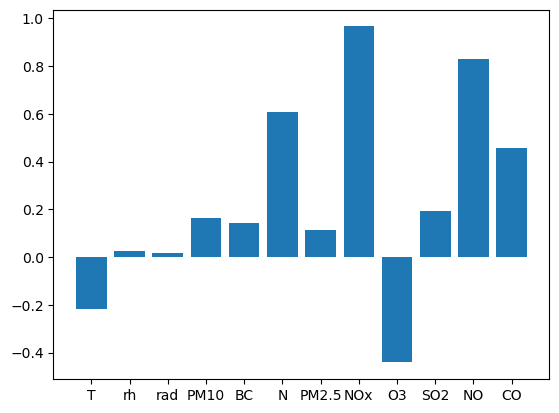

In [101]:
hel_scaled.columns.values
var_names = ['T','rh','rad','PM10','BC','CN','PM2.5','NOx','O3','SO2','NO','CO']

plt.bar(var_names, fa.components_[0])

Let's examine the monthly and dirunal cycles of the factors. For that we need to access the factzor scores $f_1$, ..., f$_k$ and we first plot their temporal evolution: 

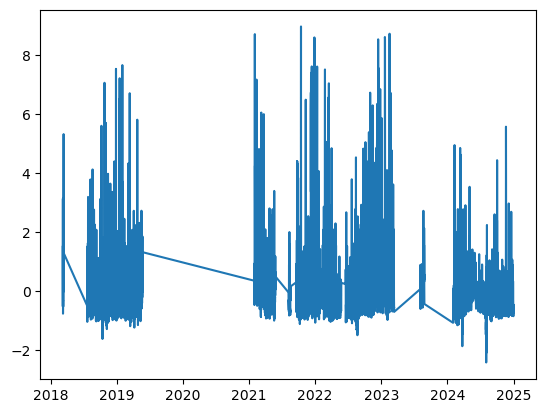

In [37]:
factor_scores = fa.transform(hel_scaled)
hel_fa_scores = pd.DataFrame(factor_scores, columns=['F1', 'F2', 'F3'], index=hel_scaled.index)

plt.plot(hel_fa_scores.index, hel_fa_scores ['F1'])

Now, the annual and diurnal cycles:

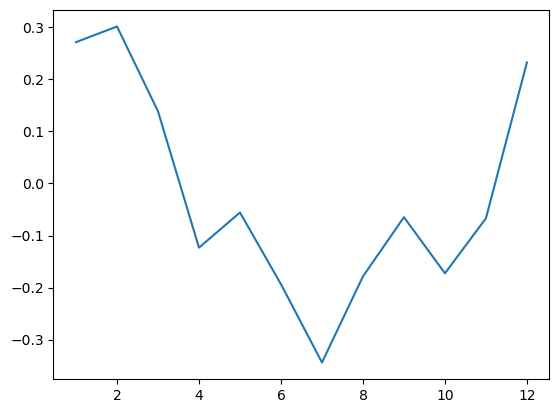

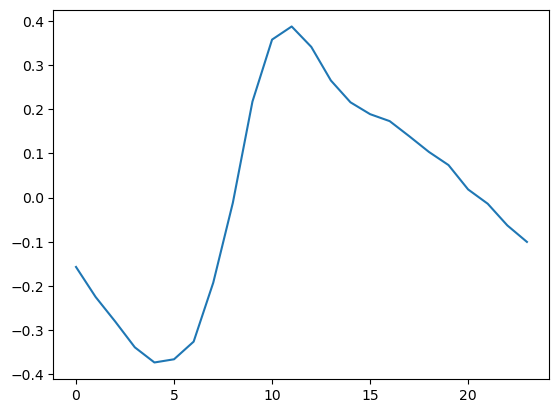

In [65]:
hel_fa_monthly = hel_fa_scores.groupby(hel_fa_scores.index.month).mean()
plt.plot(hel_fa_monthly.index, hel_fa_monthly['F1'])
plt.show()

hel_fa_daily = hel_fa_scores.groupby(hel_fa_scores.index.hour).mean()
plt.plot(hel_fa_daily.index, hel_fa_daily['F1'])
plt.show()

### 6.4.4 Non-negative matrix factorization

We see that factor analysis (but also PCA) have one major shortcomming when it comes to atmospheric (and also often other chemistry related data): The underlying latent factors can be composed of negative contribution of the individual variables and also the factor scores can be negative. 

If we are dealing with concentrations, and our latent factors are e.g. supposed to be underlying sources of the different measured concentrations, then our factor loadings need to be all positive and also the contribution (the scores) to the measured concentration can also be only positive. 

This problem is addressed in **non-negative matrix factorization**. However, there is a key difference to the above techniques. NMF tries to find a matrix decomposition such that:
$$
X \approx WH
$$
with $W \in \mathbb{R}_{\geq 0}^{n \times k}$ the source contributions (scores) and $H \in \mathbb{R}_{\geq 0}^{k \times p}$ the source profiles. It does not try to model the covariance structure and does not treat any variances of the individual variables &rarr; it is purely algebraic

Here we do not go into detail about how the solution is found but just quickly show how it works with [`sklearn.decomposition.NMF`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html). For this to work we first need to get rid of all negative values in our dataset:

In [87]:
import numpy as np

hel_nonnegative = hel_smoothed.copy()
hel_nonnegative.loc[:, 'KUM_META.t'] = hel_nonnegative.loc[:, 'KUM_META.t'] + 273.15
hel_nonnegative.loc[:, 'KUM_META.Tower_GLOB_32m'] = hel_nonnegative.loc[:, 'KUM_META.Tower_GLOB_32m'] + np.abs(hel_nonnegative.loc[:, 'KUM_META.Tower_GLOB_32m'].min())
hel_nonnegative[hel_nonnegative < 0] = np.nan
hel_nonnegative.dropna(axis=0, inplace=True)

hel_nonnegative

,KUM_META.t,KUM_META.rh,KUM_META.Tower_GLOB_32m,KUM_META.PM10_TEOM,KUM_META.BC_MAAP,KUM_META.cn,KUM_META.PM25_TEOM,KUM_META.NO_x,KUM_META.O_3,KUM_META.SO_2,KUM_META.NO,KUM_META.CO
time,,,,,,,,,,,,
2018-03-08 20:00:00,269.287500,81.283335,14.491055,15.367480,917.083330,6798.922880,9.978860,15.552660,31.234680,0.924955,2.129470,217.817030
2018-03-08 21:00:00,269.794165,83.641665,6.792920,14.318405,801.166665,6102.877555,9.978860,12.113385,34.033305,0.797070,1.077100,213.076470
2018-03-08 22:00:00,270.005000,87.866665,6.619510,13.866300,726.250000,5447.809995,9.752625,9.878625,34.876760,0.729060,0.776010,212.008410
2018-03-08 23:00:00,270.285000,92.075000,6.586555,13.600815,667.583335,4732.788450,9.214995,7.323340,35.941980,0.639310,0.418265,210.812485
2018-03-09 00:00:00,270.644165,92.983335,6.544180,12.369000,660.125000,4046.609950,9.187480,5.459100,36.532475,0.565710,0.127255,209.480430
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,271.650830,61.791665,1.845265,10.960185,0.136670,1986.073125,2.319095,1.916480,34.760415,0.077825,0.017205,118.703300
2024-12-31 20:00:00,271.448330,62.741665,1.746910,11.005430,0.162920,2075.450690,2.729390,1.881685,34.669025,0.090075,0.017505,120.909775
2024-12-31 21:00:00,271.149165,65.633330,1.746910,10.901090,0.201250,2310.131465,3.826645,1.779825,34.669025,0.093395,0.024565,120.909775


<BarContainer object of 12 artists>

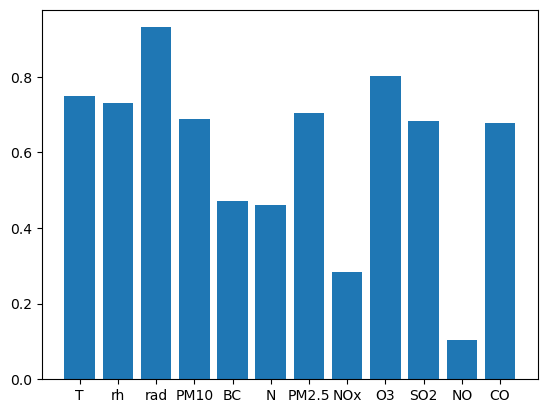

In [104]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=3, init='nndsvda', random_state=0, max_iter=1000)
W = nmf.fit_transform(hel_nonnegative)  

plt.bar(var_names, nmf.components_[1]/nmf.components_.sum(axis=0))

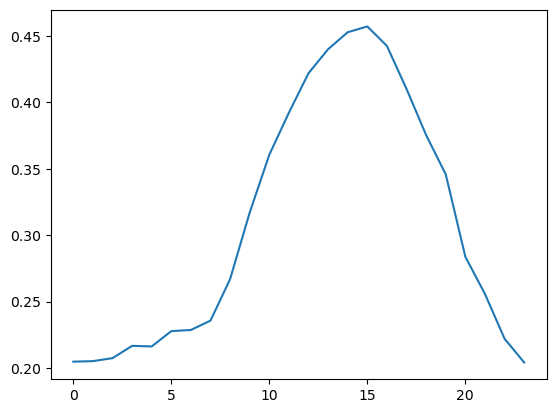

In [103]:
hel_nmf_scores = pd.DataFrame(W, columns=['F1', 'F2', 'F3'], index=hel_nonnegative.index)

hel_nmf_daily = hel_nmf_scores.groupby(hel_nmf_scores.index.hour).mean()
plt.plot(hel_nmf_daily.index, hel_nmf_daily['F2'])
plt.show()

We see that especially the factor loadings are not very clean. And this is mainly due to the fact that NMF does **not** look into the covariance structure like PCA and FA. We will see, that this is only resolved in **PMF** (Positive Matrix Factorization)!